In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import pandas as pd
import os
from glob import glob
from paulinggrl2022.cesm_functions import fixmonth, globalmean
from paulinggrl2022.twolyr import TwoLayerModel
from scipy.stats import linregress
from scipy.integrate import odeint
import cftime

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 10

In [2]:
experiments = ["piControl", "abrupt-4xCO2"]

variables = ["tas", "rsdt", "rsut", "rlut"]

models = ["ACCESS-ESM1-5",
          "CanESM5",
          "CESM2",
          "CNRM-CM6-1",
          "EC-Earth3",
          "GISS-E2-1-G",
          "GISS-E2-1-H",
          "INM-CM5-0",
          "IPSL-CM6A-LR",
          "MIROC6",
          "MIROC-ES2L",
          "MPI-ESM1-2-LR",
          "MPI-ESM1-2-HR",
          "MRI-ESM2-0",
          "NorCPM1",
          "UKESM1-0-LL"]

### Load CMIP6 data

In [3]:
droot = "../data/processed"
ddict = {}

yrs = np.arange(150)

for name in models:
    print(f"Model = {name}")
    ddict[name] = {}
    for exp in experiments:
        print(f"  Experiment: {exp}")
        ddict[name][exp] = {}
        ddir = os.path.join(droot, name, exp)
        for var in variables:
            print(f"    Variable: {var}")
            dfile = var+"_"+name+"_"+exp+"_ens_tseries_185001-199912.nc"
            ncf = os.path.join(ddir, dfile)

            ds = xr.open_dataset(ncf).squeeze()
            if "ensmem" in ds.dims and ds["ensmem"].size > 1:
                da = ds[var].isel(ensmem=0).groupby("time.year").mean("time")
                da = da.expand_dims("ensmem")
            else:
                da = ds[var].expand_dims("ensmem").groupby("time.year").mean("time")
            da = da.assign_coords({"year": ("year", yrs),
                                   "ensmem": ("ensmem", ["r1i1p1f1"])})
            ddict[name][exp][var] = da

Model = ACCESS-ESM1-5
  Experiment: piControl
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
  Experiment: abrupt-4xCO2
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
Model = CanESM5
  Experiment: piControl
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
  Experiment: abrupt-4xCO2
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
Model = CESM2
  Experiment: piControl
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
  Experiment: abrupt-4xCO2
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
Model = CNRM-CM6-1
  Experiment: piControl
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
  Experiment: abrupt-4xCO2
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
Model = EC-Earth3
  Experiment: piControl
    Variable: tas
    Variable: rsdt
    Variable: rsut
    Variable: rlut
  Experi

### Compute net TOA 

In [4]:
for name in models:
    for exp in experiments:
        ddict[name][exp]["rtmt"] = ddict[name][exp]["rsdt"] - \
            ddict[name][exp]["rsut"] - ddict[name][exp]["rlut"]

### Load forcing from Schmidt et al. (2018)

In [5]:
ddir = "../data/forcingdata"

nc_c = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.69.nonudge_novolc_icefix.cam.h0.globavg.nc")
nc_v = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.70.nonudge_volc_icefix.cam.h0.globavg.nc")

ds_c = xr.open_dataset(nc_c)
ds_v = xr.open_dataset(nc_v)

time = ds_c.time.data
timetmp = [pd.to_datetime(t) for t in time]
timenew = [cftime.DatetimeNoLeap(t.year, t.month, t.day) for t in timetmp]

ds_c = fixmonth(ds_c.assign_coords({"time": ("time", timenew)}))
ds_v = fixmonth(ds_v.assign_coords({"time": ("time", timenew)}))

ds_c = ds_c.sel(time=slice("1985-01", "2004-12"))
ds_v = ds_v.sel(time=slice("1985-01", "2004-12"))

F_sw = ds_v["FSNT"] - ds_c["FSNT"]
F_lw = -(ds_v["FLNT"] - ds_c["FLNT"])
F = F_sw + F_lw

### Plot forcing

Text(0, 0.5, 'forcing [W m$^{-2}$]')

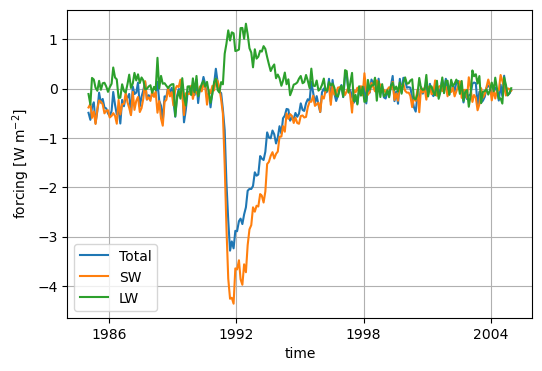

In [6]:
fig = plt.figure(1)
F.plot(label="Total")
F_sw.plot(label="SW")
F_lw.plot(label="LW")

plt.legend()
plt.grid()
plt.ylabel("forcing [W m$^{-2}$]")

### Fit model using 4xCO2 then run using volcanic forcing

In [7]:
tvec_dict = {}
T1_dict = {}
T2_dict = {}
T1_sum = {}  
param_dict = {}
SW_dict = {}
SW_sum = {}
ratio = {}

timevec = pd.date_range("1985-01", "2004-12", freq="MS")

F_sw = F_sw.assign_coords({"time": ("time", timevec)})

for name in models:
    print(f"Model: {name}")
    T = ddict[name]["abrupt-4xCO2"]["tas"] - ddict[name]["piControl"]["tas"]
    N = ddict[name]["abrupt-4xCO2"]["rtmt"] - ddict[name]["piControl"]["rtmt"]
    SW1 = ddict[name]["piControl"]["rsdt"] - ddict[name]["piControl"]["rsut"]
    SW2 = ddict[name]["abrupt-4xCO2"]["rsdt"] - ddict[name]["abrupt-4xCO2"]["rsut"]
    SW = SW2 - SW1
    
    twolayer = TwoLayerModel(model_epsilon="unit")
    
    twolayer.fit_params(T, N)
    twolayer.fit_lambda_sw(T, SW)
    
    param_dict[name] = twolayer.params
    
    T1, T2 = twolayer.solve_model(forcing=F, tstep=1/12)
    
    T1 = T1.interp(time=np.arange(240))
    T2 = T2.interp(time=np.arange(240))
    
    T1_dict[name] = T1.assign_coords({"time": ("time", timevec)})
    T2_dict[name] = T2.assign_coords({"time": ("time", timevec)})
    
    SW_dict[name] = F_sw - param_dict[name]["lam_sw"]*T1_dict[name]
    
    T1_sum[name] = T1_dict[name].sel(time=slice("1991-06", "1996-05")).sum("time")
    SW_sum[name] = SW_dict[name].sel(time=slice("1991-06", "1993-05")).sum("time")
    ratio[name] = -T1_sum[name]/SW_sum[name]
    
    print(twolayer)
    print("") 

Model: ACCESS-ESM1-5
TwoLayerModel
---Parameters---
F: [5.63196136]
lambda: [0.7239345]
T_eq: [7.77965597]
gamma: [0.71214942]
epsilon: [1.]

Model: CanESM5
TwoLayerModel
---Parameters---
F: [7.33406372]
lambda: [0.64927551]
T_eq: [11.29576521]
gamma: [0.52897484]
epsilon: [1.]

Model: CESM2
TwoLayerModel
---Parameters---
F: [6.77223801]
lambda: [0.65656379]
T_eq: [10.31466879]
gamma: [0.70812633]
epsilon: [1.]

Model: CNRM-CM6-1
TwoLayerModel
---Parameters---
F: [7.31939895]
lambda: [0.74947166]
T_eq: [9.76607841]
gamma: [0.50117106]
epsilon: [1.]

Model: EC-Earth3
TwoLayerModel
---Parameters---
F: [6.38943533]
lambda: [0.76060515]
T_eq: [8.40046283]
gamma: [0.7078609]
epsilon: [1.]

Model: GISS-E2-1-G


/Users/pauan78p/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


TwoLayerModel
---Parameters---
F: [8.56086145]
lambda: [1.63706786]
T_eq: [5.22938703]
gamma: [0.85729905]
epsilon: [1.]

Model: GISS-E2-1-H
TwoLayerModel
---Parameters---
F: [7.0282685]
lambda: [1.1259001]
T_eq: [6.24235535]
gamma: [0.64354793]
epsilon: [1.]

Model: INM-CM5-0
TwoLayerModel
---Parameters---
F: [5.64598743]
lambda: [1.4702228]
T_eq: [3.84022573]
gamma: [0.63767996]
epsilon: [1.]

Model: IPSL-CM6A-LR
TwoLayerModel
---Parameters---
F: [6.81383676]
lambda: [0.74773435]
T_eq: [9.11264372]
gamma: [0.47728024]
epsilon: [1.]

Model: MIROC6
TwoLayerModel
---Parameters---
F: [7.44800813]
lambda: [1.44257422]
T_eq: [5.16299822]
gamma: [0.68801012]
epsilon: [1.]

Model: MIROC-ES2L
TwoLayerModel
---Parameters---
F: [8.22998346]
lambda: [1.5470105]
T_eq: [5.31992733]
gamma: [0.66765441]
epsilon: [1.]

Model: MPI-ESM1-2-LR
TwoLayerModel
---Parameters---
F: [8.42652415]
lambda: [1.39331241]
T_eq: [6.04783542]
gamma: [0.61598658]
epsilon: [1.]

Model: MPI-ESM1-2-HR
TwoLayerModel
---Par

### Print out multi-model average of each parameter

In [9]:
mean_C = np.mean(np.array([param_dict[p]["C"].data[0] for p in param_dict.keys()]))
mean_C0 = np.mean(np.array([param_dict[p]["C_0"].data[0] for p in param_dict.keys()]))
mean_gam = np.mean(np.array([param_dict[p]["gamma"].data[0] for p in param_dict.keys()]))
mean_lam = np.mean(np.array([param_dict[p]["lam"].data[0] for p in param_dict.keys()]))

print(f"C = {mean_C:5.3f}")
print(f"C0 = {mean_C0:5.3f}")
print(f"gamma = {mean_gam:5.3f}")
print(f"lambda = {mean_lam:5.3f}")

C = 7.813
C0 = 94.459
gamma = 0.679
lambda = 1.062


### Load ECS data from Mark Zelinka GitHub repo

In [10]:
import json

f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test

ACCESS-ESM1-5 = 3.8839034758064814
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
CNRM-CM6-1 = 4.9036506204610255
EC-Earth3 = 4.2600669989023405
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253567
MIROC6 = 2.601790969650521
MIROC-ES2L = 2.6605264351565174
MPI-ESM1-2-LR = 3.0254401947450527
MPI-ESM1-2-HR = 2.9797516932086876
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.0317257208870005
UKESM1-0-LL = 5.359162439690016


### Compute correlation between ECS and integrated dT

In [11]:
ecs_array = np.array([ecs_dict[name] for name in models])
t1_sum_array = np.array([float(T1_sum[name].data) for name in models])

slope_t, intcpt_t, r_value_t, p_value_t, std_err_t = linregress(ecs_array, t1_sum_array)

print(f"Temperature r = {r_value_t:5.4f}")

import pickle as pkl

out = {"slope": slope_t,
       "intcpt": intcpt_t,
       "r_value": r_value_t,
       "p_value": p_value_t,
       "std_err": std_err_t}

with open("integrate_T_twolyr_result.pkl", "wb") as f:
    pkl.dump(out, f)

Temperature r = -0.8076


### Define colormap

In [13]:
colors = pl.cm.tab20.colors

### Plot SW anomaly from two-layer model

Text(0, 0.5, '$\\Delta$SW [W m$^{-2}$]')

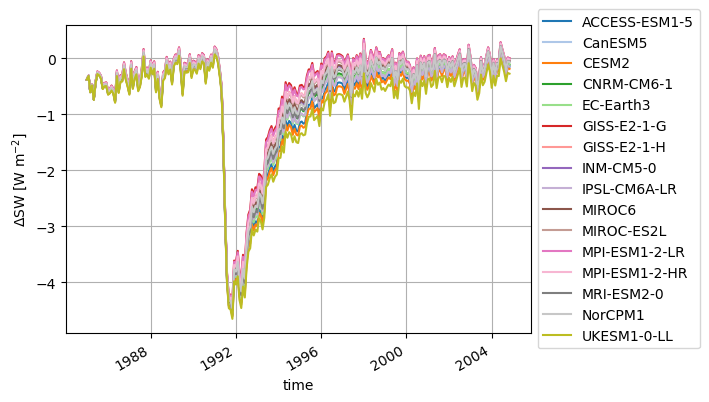

In [14]:
fig = plt.figure(1)
for n, name in enumerate(models):
    if n < 3:
        color = colors[n]
    else:
        color = colors[n+1]
        
    SW_dict[name].plot(label=name, color=color)
    
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.title("")
plt.grid()
plt.ylabel("$\Delta$SW [W m$^{-2}$]")

### Serialize out two-layer model ratio

In [15]:
import pickle as pkl

with open("twolyr_unitepsilon_ratio.pkl", "wb") as f:
    pkl.dump(ratio, f)

### Compute and plot correlation for integrated ratio

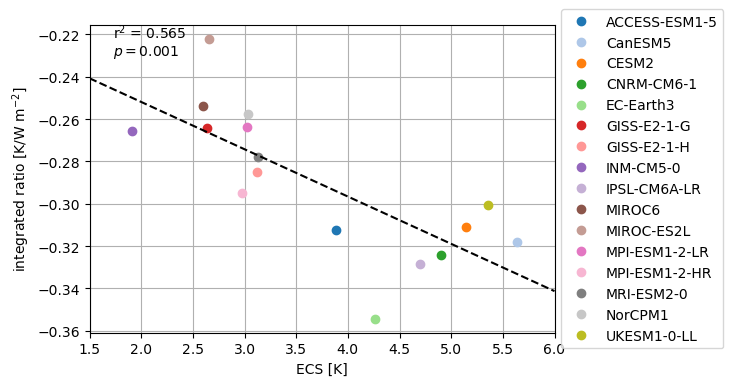

In [17]:
fig = plt.figure(1)

for n, name in enumerate(models):
    if n < 3:
        color = colors[n]
    else:
        color = colors[n+1]
    plt.plot(ecs_dict[name], ratio[name], 'o', color=color, label=name)
    
ratio_array = np.array([float(ratio[name].data) for name in models])

slope_r, intcpt_r, r_value_r, p_value_r, std_err_r = linregress(ecs_array, ratio_array)

x = np.arange(1.5, 6.01, 0.1)
y = slope_r*x + intcpt_r

plt.plot(x, y, "k--")
plt.xlim(1.5, 6)

plt.annotate(f"r$^2$ = {r_value_r**2:5.3f}\n$p=${p_value_r:5.3f}",
             xy=(0.05, 0.9),
             xycoords="axes fraction")

plt.grid()
plt.ylabel("integrated ratio [K/W m$^{-2}$]")
plt.xlabel("ECS [K]")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

out = {"slope": slope_r,
       "intcpt": intcpt_r,
       "r_value": r_value_r,
       "p_value": p_value_r,
       "std_err": std_err_r}

with open("integrate_ratio_twolyr_result.pkl", "wb") as f:
    pkl.dump(out, f)

### Compute and plot correlation for integrated SW

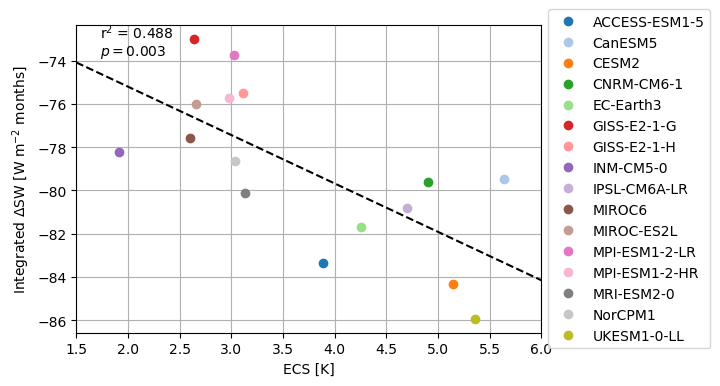

In [18]:
fig = plt.figure(1)

for n, name in enumerate(models):
    if n < 3:
        color = colors[n]
    else:
        color = colors[n+1]
    plt.plot(ecs_dict[name], SW_sum[name], 'o', color=color, label=name)
    
sw_array = np.array([float(SW_sum[name].data) for name in models])

slope_s, intcpt_s, r_value_s, p_value_s, std_err_s = linregress(ecs_array, sw_array)

y = slope_s*x + intcpt_s

plt.plot(x, y, "k--")
plt.xlim(1.5, 6)

plt.annotate(f"r$^2$ = {r_value_s**2:5.3f}\n$p=${p_value_s:5.3f}",
             xy=(0.05, 0.9),
             xycoords="axes fraction")

plt.grid()
plt.ylabel("Integrated $\Delta$SW [W m$^{-2}$ months]")
plt.xlabel("ECS [K]")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

out = {"slope": slope_s,
       "intcpt": intcpt_s,
       "r_value": r_value_s,
       "p_value": p_value_s,
       "std_err": std_err_s}

with open("integrate_sw_twolyr_result.pkl", "wb") as f:
    pkl.dump(out, f)

### Plot combined figure for paper

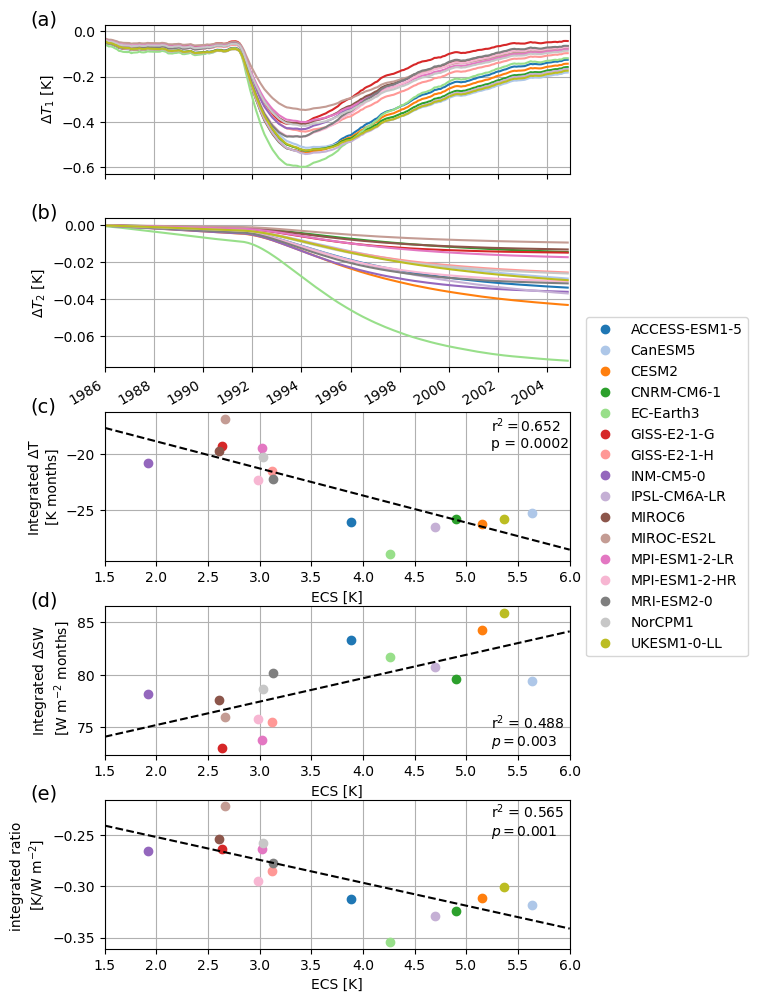

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(6, 12))


for n, name in enumerate(models):
    if n < 3:
        color = colors[n]
    else:
        color = colors[n+1]

    T1_dict[name].plot.line(
        x="time", 
        label=name, 
        color=color,
        ax=ax1,
        add_legend=False
    )
    T2_dict[name].plot.line(
        x="time", 
        label=name, 
        color=color,
        ax=ax2,
        add_legend=False
    )
    
    ax3.plot(ecs_dict[name], T1_sum[name], "o", color=color, label=name)
    
t1 = T1_dict[name].time.sel(time="1986-01").data[0]
t2 = T1_dict[name].time.sel(time="2004-12").data[0]

ax1.set_xlim(t1, t2)
ax2.set_xlim(t1, t2)

ax1.set_xticklabels("")
ax1.set_xlabel("")
ax2.set_xlabel("")

ax1.set_title("")
ax2.set_title("")

ax1.grid()
ax2.grid()

ax1.set_ylabel("$\Delta T_1$ [K]")
ax2.set_ylabel("$\Delta T_2$ [K]")    

ax3.grid()
ax3.set_xlim(1.5, 6)

x = np.arange(1.5, 6.01, 0.1)
ax3.plot(x, slope_t*x + intcpt_t, "k--")

ax3.annotate(
    f"r$^2 =${r_value_t**2:5.3f}\np = {p_value_t:5.4f}", 
    xy=(0.83, 0.76), 
    xycoords="axes fraction"
)

ax3.set_ylabel("Integrated $\Delta$T \n[K months]")
ax3.set_xlabel("ECS [K]")
ax3.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.subplots_adjust(hspace=0.3)

ax1.annotate("(a)", xy=(-0.16, 1), xycoords="axes fraction", fontsize=14)
ax2.annotate("(b)", xy=(-0.16, 1), xycoords="axes fraction", fontsize=14)
ax3.annotate("(c)", xy=(-0.16, 1), xycoords="axes fraction", fontsize=14)
ax4.annotate("(d)", xy=(-0.16, 1), xycoords="axes fraction", fontsize=14)
ax5.annotate("(e)", xy=(-0.16, 1), xycoords="axes fraction", fontsize=14)

for n, name in enumerate(models):
    if n < 3:
        color = colors[n]
    else:
        color = colors[n+1]
    ax4.plot(ecs_dict[name], -SW_sum[name], 'o', color=color, label=name)

y = -slope_s*x - intcpt_s

ax4.plot(x, y, "k--")
ax4.set_xlim(1.5, 6)

ax4.annotate(f"r$^2$ = {r_value_s**2:5.3f}\n$p=${p_value_s:5.3f}",
             xy=(0.83, 0.06),
             xycoords="axes fraction")

ax4.grid()
ax4.set_ylabel("Integrated $\Delta$SW\n [W m$^{-2}$ months]")
ax4.set_xlabel("ECS [K]")

for n, name in enumerate(models):
    if n < 3:
        color = colors[n]
    else:
        color = colors[n+1]
    ax5.plot(ecs_dict[name], ratio[name], 'o', color=color, label=name)

y = slope_r*x + intcpt_r

ax5.plot(x, y, "k--")
ax5.set_xlim(1.5, 6)

ax5.annotate(f"r$^2$ = {r_value_r**2:5.3f}\n$p=${p_value_r:5.3f}",
             xy=(0.83, 0.76),
             xycoords="axes fraction")

ax5.grid()
ax5.set_ylabel("integrated ratio \n[K/W m$^{-2}$]")
ax5.set_xlabel("ECS [K]")

fig.savefig("../figures/twolyr_model_allcorr.png",
            bbox_inches="tight", dpi=300)